In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install git+https://github.com/tmabraham/UPIT.git

  Cloning https://github.com/tmabraham/UPIT.git to /tmp/pip-req-build-2bgvx4_n
  Running command git clone --filter=blob:none --quiet https://github.com/tmabraham/UPIT.git /tmp/pip-req-build-2bgvx4_n
  Resolved https://github.com/tmabraham/UPIT.git to commit 3c38f943ed9b28659d50f6c2a94b3cc290754870
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
import os
import glob
import torch
import tifffile as tiff
import logging
from upit.data.unpaired import get_dls
from upit.data.unpaired import get_image_files
from upit.data.unpaired import RandPair
from upit.data.unpaired import *
from upit.models.cyclegan import CycleGAN
from upit.train.cyclegan import CycleGANLoss, cycle_learner
from upit.metrics import Adam
from functools import partial
from fastai.vision.all import aug_transforms, Normalize

In [ ]:
# ----- Experiment Parameters -----
DOMAINA_STACKS_FOLDER = "/content/drive/MyDrive/GAN/MUSE_stitched_acq_5/"
domainA_extracted_folder = "/content/drive/MyDrive/GAN/extracted_domainA/"
DOMAINB_FOLDER = "/content/drive/MyDrive/GAN/HE_images_patched/"
BATCH_SIZE = 12
LOAD_SIZE = 512
CROP_SIZE = 256
FLAT_EPOCHS = 100         # Number of epochs with constant learning rate.
LIN_EPOCHS = 100          # Number of epochs with linear decay.
LEARNING_RATE = 7e-5
MODEL_FILTERS = 64
EXPERIMENT_NAME = "cyclegan_first_experiment"
SAVE_DIR = "saved_models"       # Where checkpoints are saved.
# ---------------------------------

(512, 512, 3)


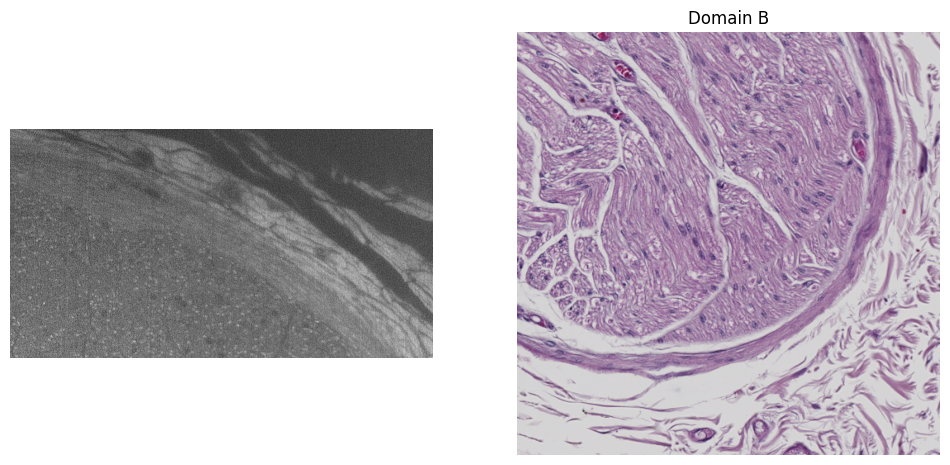

In [ ]:
from PIL import Image
import os, random

def get_unpaired_images(root_A, root_B, transform=None):
    """
    Randomly selects and returns one image from Domain A and one from Domain B.

    Args:
      root_A (str): Path to the folder containing Domain A images.
      root_B (str): Path to the folder containing Domain B images.
      transform (callable, optional): An optional transform to apply to both images.

    Returns:
      (img_A, img_B): A tuple of PIL images (or transformed images if a transform is provided).
    """
    # List all valid image files for Domain A.
    files_A = sorted([
        os.path.join(root_A, f)
        for f in os.listdir(root_A)
        if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))
    ])

    # List all valid image files for Domain B.
    files_B = sorted([
        os.path.join(root_B, f)
        for f in os.listdir(root_B)
        if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))
    ])

    if not files_A or not files_B:
        raise ValueError("One or both directories do not contain any image files.")

    # Randomly select one image file from each domain.
    file_A = random.choice(files_A)
    file_B = random.choice(files_B)

    # Open the images and convert to RGB.
    img_A = tiff.imread(file_A)
    img_B = tiff.imread(file_B)


    return img_A, img_B

img_A, img_B = get_unpaired_images(domainA_extracted_folder, DOMAINB_FOLDER)
print(img_B.shape)
# Plot images side-by-side.
plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.imshow(img_A, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_B)
plt.title("Domain B")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

class TiffToRGB:
    def __call__(self, image, **kwargs):
        """
        Convert a TIFF image (as a NumPy array) to a standard RGB image.
          - Scales 16-bit images to [0,1].
          - Replicates channels for grayscale images.
          - Leaves RGB images unchanged.
        Returns a uint8 NumPy array.
        """
        # If 16-bit, scale to [0,1]
        if image.dtype == np.uint16:
            image = image.astype(np.float32) / 65535.0

        # If grayscale (2D) or single-channel, replicate channels.
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.ndim == 3:
            if image.shape[-1] == 1:
                image = np.concatenate([image] * 3, axis=-1)
            elif image.shape[-1] == 3:
                pass  # Already RGB.
            else:
                raise ValueError("Unexpected number of channels: expected 1 or 3.")
        else:
            raise ValueError("Unexpected image shape.")

        # If in float format, assume [0,1] and convert to uint8.
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        return image

# Pipeline for Domain A: originally grayscale (converted to RGB) and normalized (ImageNet stats).
transform_A = A.Compose([
    A.Lambda(image=TiffToRGB()),  # Custom TIFF-to-RGB conversion.
    A.Resize(512, 512),
    A.RandomCrop(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    ToTensorV2(),
])

# Pipeline for Domain B: already RGB; no normalization applied.
transform_B = A.Compose([
    A.Lambda(image=TiffToRGB()),
    A.Resize(512, 512),
    A.RandomCrop(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    ToTensorV2(),
])




In [ ]:
from torch.utils.data import Dataset
import os, random
import tifffile as tiff

class UnpairedTiffDataset(Dataset):
    def __init__(self, root_A, root_B, transform_A=None, transform_B=None):
        """
        Args:
            root_A (str): Path to Domain A TIFF images.
            root_B (str): Path to Domain B TIFF images.
            transform_A (callable, optional): Albumentations pipeline for Domain A images.
            transform_B (callable, optional): Albumentations pipeline for Domain B images.
        """
        self.root_A = root_A
        self.root_B = root_B
        self.transform_A = transform_A
        self.transform_B = transform_B

        self.files_A = sorted([
            os.path.join(root_A, f)
            for f in os.listdir(root_A)
            if f.lower().endswith(('.tif', '.tiff'))
        ])
        self.files_B = sorted([
            os.path.join(root_B, f)
            for f in os.listdir(root_B)
            if f.lower().endswith(('.tif', '.tiff'))
        ])

        if not self.files_A or not self.files_B:
            raise ValueError("One or both directories do not contain any TIFF images.")

        self.len_A = len(self.files_A)
        self.len_B = len(self.files_B)
        self.length = max(self.len_A, self.len_B)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Cycle through Domain A files and randomly pick from Domain B
        file_A = self.files_A[index % self.len_A]
        file_B = random.choice(self.files_B)

        img_A = tiff.imread(file_A)
        img_B = tiff.imread(file_B)

        # Apply albumentations transforms (they expect a dict with key 'image')
        if self.transform_A:
            img_A = self.transform_A(image=img_A)['image']
        if self.transform_B:
            img_B = self.transform_B(image=img_B)['image']

        return img_A, img_B


Dataset size: 1368
Domain A batch shape: torch.Size([8, 3, 256, 256])
Domain B batch shape: torch.Size([8, 3, 256, 256])


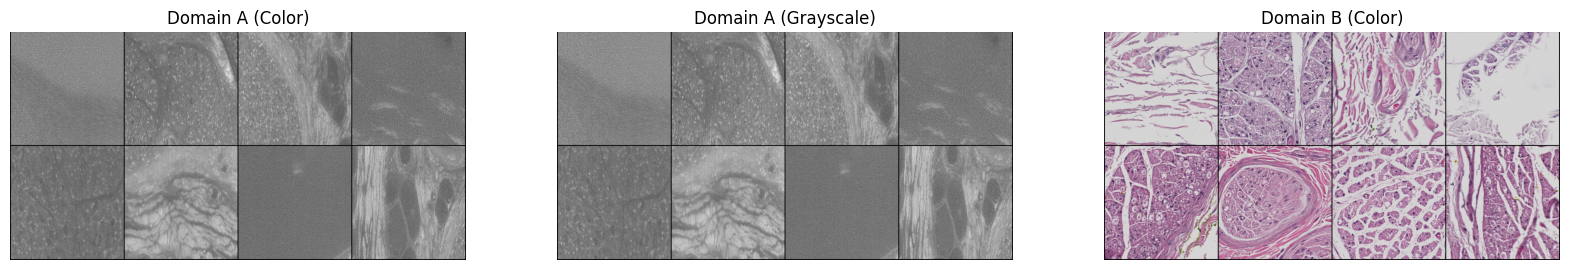

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Set your folder paths (replace these with your actual paths).
root_A = domainA_extracted_folder   # Domain A folder (e.g., zarr images)
root_B = DOMAINB_FOLDER              # Domain B folder (H&E images)

# Create the dataset with separate albumentations transforms.
dataset = UnpairedTiffDataset(root_A, root_B, transform_A=transform_A, transform_B=transform_B)
print(f"Dataset size: {len(dataset)}")

# Create a DataLoader.
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Fetch one batch.
batch_A, batch_B = next(iter(dataloader))
print("Domain A batch shape:", batch_A.shape)  # Expected: (8, 3, 256, 256)
print("Domain B batch shape:", batch_B.shape)  # Expected: (8, 3, 256, 256)

# Create grids for visualization.
grid_A = make_grid(batch_A, nrow=4)       # Domain A grid (color)
grid_A_gray = grid_A.float().mean(dim=0)          # Domain A grid as grayscale (averaging channels)
grid_B = make_grid(batch_B, nrow=4)       # Domain B grid (color)

# Plotting the results.
plt.figure(figsize=(20, 10))

# Plot Domain A (color)
plt.subplot(1, 3, 1)
plt.imshow(grid_A.permute(1, 2, 0).cpu().numpy())
plt.title("Domain A (Color)")
plt.axis("off")

# Plot Domain A as grayscale.
plt.subplot(1, 3, 2)
plt.imshow(grid_A_gray.cpu().numpy(), cmap='gray')
plt.title("Domain A (Grayscale)")
plt.axis("off")

# Plot Domain B (color).
plt.subplot(1, 3, 3)
plt.imshow(grid_B.permute(1, 2, 0).cpu().numpy())
plt.title("Domain B (Color)")
plt.axis("off")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create checkpoint directory
save_dir = "/content/drive/MyDrive/GAN/checkpoints"
os.makedirs(save_dir, exist_ok=True)


Using device: cuda


In [ ]:
# Residual Block for the generator.
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator: ResNet-based.
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        super(ResnetGenerator, self).__init__()
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Discriminator: 70x70 PatchGAN.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)


In [ ]:
# CycleGAN model: bundles two generators and two discriminators.
class CycleGAN(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        super(CycleGAN, self).__init__()
        # According to UPIT docs, forward returns (fake_A, fake_B, idt_A, idt_B)
        # Here, we define:
        # fake_A: output of G_B(real_B) for B→A
        # fake_B: output of G_A(real_A) for A→B
        # idt_A: identity output when real_A is fed to G_B
        # idt_B: identity output when real_B is fed to G_A
        self.G_A = ResnetGenerator(input_nc, output_nc, ngf, n_blocks)  # A->B
        self.G_B = ResnetGenerator(input_nc, output_nc, ngf, n_blocks)  # B->A
        self.D_A = NLayerDiscriminator(input_nc)
        self.D_B = NLayerDiscriminator(input_nc)

    def forward(self, inputs):
        real_A, real_B = inputs
        # Generate fake images.
        fake_B = self.G_A(real_A)  # A→B output.
        fake_A = self.G_B(real_B)  # B→A output.
        # Identity mapping.
        idt_A = self.G_B(real_A)   # For domain A, should be near real_A.
        idt_B = self.G_A(real_B)   # For domain B, should be near real_B.
        return fake_A, fake_B, idt_A, idt_B

# Loss Functions
# Adversarial loss: Using LSGAN (MSELoss).
class AdversarialLoss(nn.Module):
    def __init__(self):
        super(AdversarialLoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)
        return self.loss(pred, target)

# CycleGAN loss encapsulating cycle and identity losses.
class CycleGANLoss(nn.Module):
    def __init__(self, lambda_cycle=10.0, lambda_idt=0.5):
        super(CycleGANLoss, self).__init__()
        self.lambda_cycle = lambda_cycle
        self.lambda_idt = lambda_idt
        self.adv_loss = AdversarialLoss()   # Adversarial loss.
        self.cycle_loss = nn.L1Loss()         # Cycle consistency loss.
        self.identity_loss = nn.L1Loss()      # Identity loss.

    def forward(self, outputs, targets):
        # Unpack outputs.
        fake_A, fake_B, idt_A, idt_B = outputs
        real_A, real_B = targets

        # Cycle consistency: We need to compute cycle outputs externally.
        # Here we assume they are computed in the training loop.
        # In this loss class, we only compute the identity loss.
        # Identity loss:
        self.id_loss_A = self.identity_loss(idt_A, real_A)
        self.id_loss_B = self.identity_loss(idt_B, real_B)

        # Total loss from the generators will be combined externally.
        # This loss function doesn't compute adversarial or cycle loss by itself.
        # Return identity losses sum as a placeholder.
        return self.id_loss_A + self.id_loss_B

# Instantiate the model and move to device.
MODEL_FILTERS = 64  # adjust as needed
model = CycleGAN(3, 3, MODEL_FILTERS).to(device)
model = model.to(device)

# ---------------------
#  Training Loss Setup
# ---------------------
criterion_GAN = AdversarialLoss()
criterion_cycle = nn.L1Loss()
criterion_idt = nn.L1Loss()
lambda_cycle = 10.0
lambda_idt = 0.5


In [ ]:
# Optimizers for generators and discriminators.
optimizer_G = optim.Adam(list(model.G_A.parameters()) + list(model.G_B.parameters()),
                         lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(list(model.D_A.parameters()) + list(model.D_B.parameters()),
                         lr=0.0002, betas=(0.5, 0.999))

# Learning rate scheduler: constant for first n_epochs_static, then linear decay.
n_epochs = 200
n_epochs_static = 100

def lambda_rule(epoch):
    if epoch < n_epochs_static:
        return 1.0
    else:
        return 1.0 - (epoch - n_epochs_static) / (n_epochs - n_epochs_static)

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)

# Containers for logging.
epoch_loss_history_G = []       # Total generator loss.
epoch_loss_history_D = []       # Total discriminator loss.
epoch_lr_history_G = []
epoch_lr_history_D = []


In [244]:
for epoch in range(n_epochs):
    model.train()
    loss_G_total_epoch = 0.0
    loss_D_total_epoch = 0.0
    count = 0

    for i, (real_A, real_B) in enumerate(dataloader):
        # Scale and move images to [0,1] on device.
        real_A = real_A.to(device).float() / 255.0
        real_B = real_B.to(device).float() / 255.0

        # --------------- Train Generators ---------------
        optimizer_G.zero_grad()
        # Forward pass: model returns (fake_A, fake_B, idt_A, idt_B)
        fake_A, fake_B, idt_A, idt_B = model((real_A, real_B))
        # Cycle consistency: reconstruct images.
        cycle_A = model.G_B(fake_B)
        cycle_B = model.G_A(fake_A)

        # Adversarial losses.
        loss_GAN_A2B = criterion_GAN(model.D_B(fake_B), True)
        loss_GAN_B2A = criterion_GAN(model.D_A(fake_A), True)
        loss_GAN = loss_GAN_A2B + loss_GAN_B2A

        # Cycle consistency losses.
        loss_cycle_A = criterion_cycle(cycle_A, real_A)
        loss_cycle_B = criterion_cycle(cycle_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle

        # Identity losses.
        loss_idt_A = criterion_idt(idt_A, real_A) * lambda_cycle * lambda_idt
        loss_idt_B = criterion_idt(idt_B, real_B) * lambda_cycle * lambda_idt
        loss_idt = loss_idt_A + loss_idt_B

        # Total generator loss.
        loss_G = loss_GAN + loss_cycle + loss_idt
        loss_G.backward()
        optimizer_G.step()

        # --------------- Train Discriminators ---------------
        optimizer_D.zero_grad()
        # Discriminator A: real_A vs fake_A.
        loss_D_A = 0.5 * (criterion_GAN(model.D_A(real_A), True) +
                          criterion_GAN(model.D_A(fake_A.detach()), False))
        # Discriminator B: real_B vs fake_B.
        loss_D_B = 0.5 * (criterion_GAN(model.D_B(real_B), True) +
                          criterion_GAN(model.D_B(fake_B.detach()), False))
        loss_D = loss_D_A + loss_D_B
        loss_D.backward()
        optimizer_D.step()

        loss_G_total_epoch += loss_G.item()
        loss_D_total_epoch += loss_D.item()
        count += 1

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] Batch [{i}/{len(dataloader)}] - "
                  f"Gen Loss: {loss_G.item():.4f} (GAN: {loss_GAN.item():.4f}, Cycle: {loss_cycle.item():.4f}, Id: {loss_idt.item():.4f}) | "
                  f"Disc Loss: {loss_D.item():.4f}")

    avg_loss_G = loss_G_total_epoch / count
    avg_loss_D = loss_D_total_epoch / count
    current_lr_G = optimizer_G.param_groups[0]['lr']
    current_lr_D = optimizer_D.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{n_epochs}] finished: Avg Gen Loss = {avg_loss_G:.4f}, Avg Disc Loss = {avg_loss_D:.4f}, "
          f"LR_G = {current_lr_G:.6f}, LR_D = {current_lr_D:.6f}")

    epoch_loss_history_G.append(avg_loss_G)
    epoch_loss_history_D.append(avg_loss_D)
    epoch_lr_history_G.append(current_lr_G)
    epoch_lr_history_D.append(current_lr_D)

    scheduler_G.step()
    scheduler_D.step()

    # Save model checkpoint.
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch+1}.pth"))

    # --------------- Plot Sample Predictions ---------------
    model.eval()
    with torch.no_grad():
        sample_A, sample_B = next(iter(dataloader))
        sample_A = sample_A.to(device).float() / 255.0
        sample_B = sample_B.to(device).float() / 255.0

        fake_A, fake_B, _, _ = model((sample_A, sample_B))
        cycle_A = model.G_B(fake_B)
        cycle_B = model.G_A(fake_A)

        # Note: According to our CycleGAN model:
        # fake_A is B→A, fake_B is A→B,
        # so we plot:
        # Top row: Real A, Fake B (A→B), Cycle A (A→B→A)
        # Bottom row: Real B, Fake A (B→A), Cycle B (B→A→B)
        grid_real_A = make_grid(sample_A, nrow=4)
        grid_fake_B = make_grid(fake_B, nrow=4)
        grid_cycle_A = make_grid(cycle_A, nrow=4)
        grid_real_B = make_grid(sample_B, nrow=4)
        grid_fake_A = make_grid(fake_A, nrow=4)
        grid_cycle_B = make_grid(cycle_B, nrow=4)

        plt.figure(figsize=(18, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(grid_real_A.permute(1, 2, 0).cpu().numpy())
        plt.title("Real A")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(grid_fake_B.permute(1, 2, 0).cpu().numpy())
        plt.title("Fake B (A → B)")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        plt.imshow(grid_cycle_A.permute(1, 2, 0).cpu().numpy())
        plt.title("Cycle A (A → B → A)")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        plt.imshow(grid_real_B.permute(1, 2, 0).cpu().numpy())
        plt.title("Real B")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(grid_fake_A.permute(1, 2, 0).cpu().numpy())
        plt.title("Fake A (B → A)")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        plt.imshow(grid_cycle_B.permute(1, 2, 0).cpu().numpy())
        plt.title("Cycle B (B → A → B)")
        plt.axis("off")

        plt.suptitle(f"Epoch {epoch+1} Predictions", fontsize=16)
        plt.show()


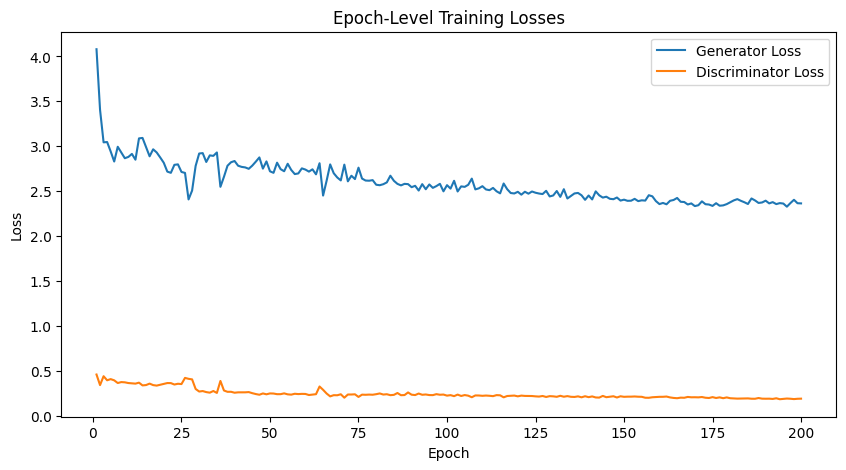

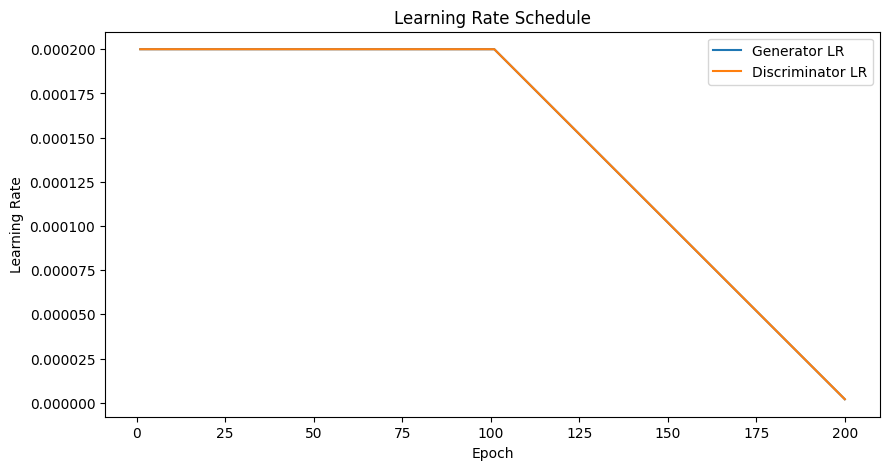

In [245]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), epoch_loss_history_G, label='Generator Loss')
plt.plot(range(1, n_epochs+1), epoch_loss_history_D, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch-Level Training Losses")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), epoch_lr_history_G, label='Generator LR')
plt.plot(range(1, n_epochs+1), epoch_lr_history_D, label='Discriminator LR')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.show()


=============================Test: Acquisition_4=============================


In [246]:
import os
import glob
import tifffile as tiff
import logging

# Set up logging.
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def extract_tiff_stack(stack_path, output_dir):
    """
    Extracts all slices from a multi-page TIFF stack and saves them
    as individual TIFF images in output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    logger.info(f"Extracting from {stack_path} ...")
    stack = tiff.imread(stack_path)
    base_name = os.path.splitext(os.path.basename(stack_path))[0]
    for i, img in enumerate(stack):
        img_filename = f"{base_name}_slice_{i:02d}.tiff"
        img_path = os.path.join(output_dir, img_filename)
        tiff.imwrite(img_path, img)
        logger.info(f"Saved {img_path}")

def extract_all_tiff_stacks(input_folder, output_folder):
    """
    Processes all TIFF stack files in input_folder and extracts all images
    from each into the output_folder.
    """
    os.makedirs(output_folder, exist_ok=True)
    tiff_files = glob.glob(os.path.join(input_folder, "**/*.tif"), recursive=True) + \
                 glob.glob(os.path.join(input_folder, "**/*.tiff"), recursive=True)

    logger.info(f"Found {len(tiff_files)} TIFF files in '{input_folder}'.")
    if not tiff_files:
        logger.error("No TIFF stack files found in the input folder!")
        return
    for stack_path in tiff_files:
        extract_tiff_stack(stack_path, output_folder)


In [247]:
# Define your input and output folders for the TIFF stacks.
input_folder = '/content/drive/MyDrive/GAN/MUSE_stitched_acq_4/'       # Folder containing multi-page TIFF stacks.
output_folder = '/content/drive/MyDrive/GAN/test_data/'   # Folder to save individual slices.

# Run the extraction.
extract_all_tiff_stacks(input_folder, output_folder)

# List the extracted files.
extracted_files = glob.glob(os.path.join(output_folder, "*.tif")) + \
                  glob.glob(os.path.join(output_folder, "*.tiff"))
logger.info(f"Total extracted TIFF images: {len(extracted_files)}")
print(f"Total extracted TIFF images: {len(extracted_files)}")


Total extracted TIFF images: 6250


In [260]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define a deterministic transform for testing (no randomness).
transform_test = A.Compose([
    A.Lambda(image=TiffToRGB()),  # Your custom TIFF-to-RGB conversion.
    A.Resize(512, 512),
    A.CenterCrop(height=256, width=256),
    ToTensorV2(),
])

# Use the extracted slices as test data. (Assume both domains are in the same folder for testing.)
# You may adjust this if you have separate folders for Domain A and Domain B.
root_A_test = output_folder  # For testing, we use the extracted slices.
root_B_test = DOMAINB_FOLDER

# Create the test dataset.
test_dataset = UnpairedTiffDataset(root_A_test, root_B_test, transform_A=transform_test, transform_B=transform_test)
print(f"Test dataset size: {len(test_dataset)}")

# Create the test DataLoader.
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)

# Optionally, verify one batch.
batch_A, batch_B = next(iter(test_loader))
print("Test Domain A batch shape:", batch_A.shape)
print("Test Domain B batch shape:", batch_B.shape)


Test dataset size: 6250
Test Domain A batch shape: torch.Size([8, 3, 256, 256])
Test Domain B batch shape: torch.Size([8, 3, 256, 256])


In [253]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn

# Set up device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate your CycleGAN model.
MODEL_FILTERS = 64  # Adjust as needed.
model = CycleGAN(3, 3, MODEL_FILTERS).to(device)
model = model.to(device)

# Load the trained model checkpoint.
checkpoint_path = "/content/drive/MyDrive/GAN/checkpoints/model_epoch_200.pth"  # Adjust as needed.
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Model loaded and set to evaluation mode.")

# Define loss functions.
criterion_cycle = nn.L1Loss()
criterion_idt = nn.L1Loss()
criterion_GAN = AdversarialLoss()

# Hyperparameters (same as used during training).
lambda_cycle = 10.0
lambda_idt = 0.5

Using device: cuda
Model loaded and set to evaluation mode.


<ipython-input-253-72ce54bb221c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


Test Metrics:
Cycle Consistency Loss: 0.8711
Identity Loss:          0.3829
G Adversarial Loss:     1.3475
D Loss:                 1.0474


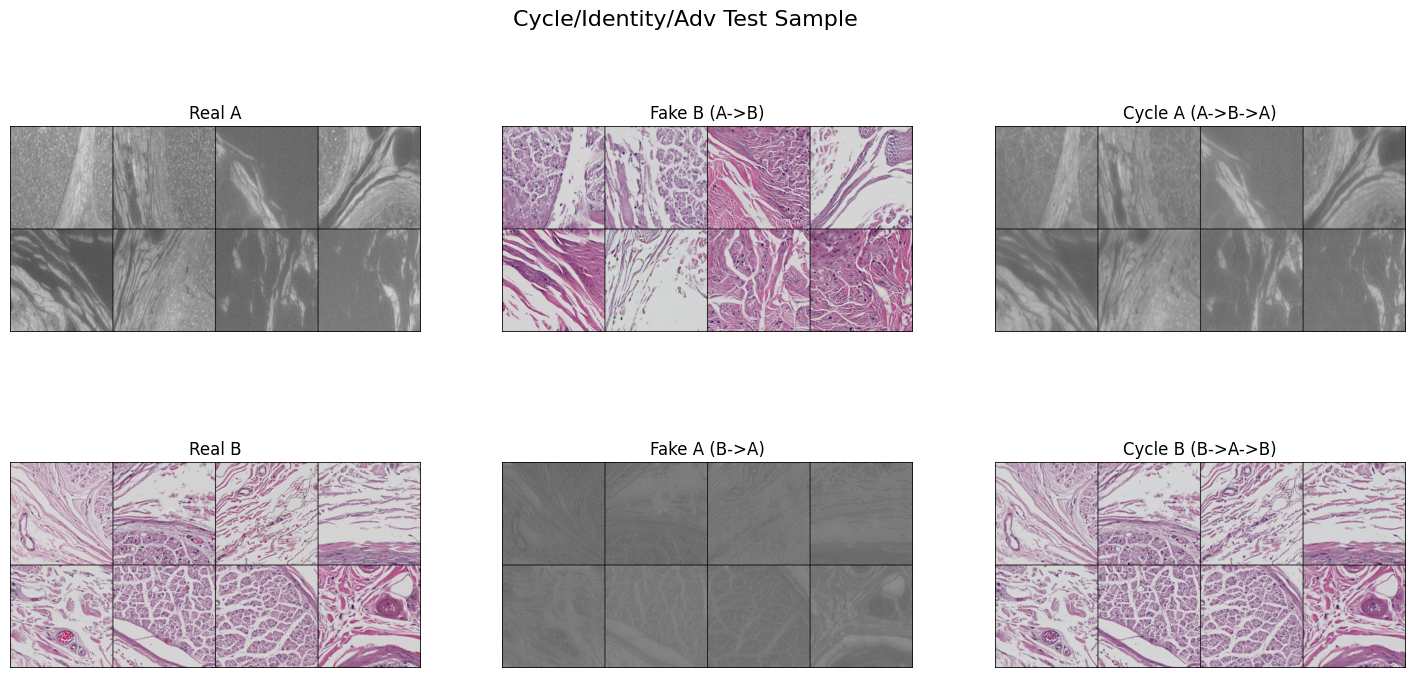

In [297]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # We'll stay in eval mode for testing

# Suppose these are your test losses from training time:
criterion_cycle = nn.L1Loss()
criterion_idt = nn.L1Loss()
criterion_adv = nn.MSELoss()  # LSGAN adversarial loss

lambda_cycle = 10.0
lambda_idt = 0.5

# Accumulators
total_cycle_loss = 0.0
total_id_loss = 0.0
total_g_adv_loss = 0.0  # Generator adversarial loss
total_d_loss = 0.0      # Discriminator loss
count = 0

with torch.no_grad():
    for real_A, real_B in test_loader:
        # Move and scale images to [0,1]
        real_A = real_A.to(device).float() / 255.0
        real_B = real_B.to(device).float() / 255.0

        # Forward pass
        fake_A, fake_B, idt_A, idt_B = model((real_A, real_B))
        cycle_A = model.G_B(fake_B)  # A→B→A
        cycle_B = model.G_A(fake_A)  # B→A→B

        # ---------------------
        # Cycle + Identity Loss
        # ---------------------
        loss_cycle_A = criterion_cycle(cycle_A, real_A)
        loss_cycle_B = criterion_cycle(cycle_B, real_B)
        cycle_loss = (loss_cycle_A + loss_cycle_B) * lambda_cycle

        idt_loss_A = criterion_idt(idt_A, real_A) * lambda_cycle * lambda_idt
        idt_loss_B = criterion_idt(idt_B, real_B) * lambda_cycle * lambda_idt
        id_loss = idt_loss_A + idt_loss_B

        total_cycle_loss += cycle_loss.item()
        total_id_loss += id_loss.item()

        # ------------------------
        # Generator Adversarial Loss
        # ------------------------
        # For A->B: generator wants D_B(fake_B) close to 1
        pred_fake_B = model.D_B(fake_B)  # D_B sees A->B
        loss_gan_A2B = criterion_adv(pred_fake_B, torch.ones_like(pred_fake_B, device=device))

        # For B->A: generator wants D_A(fake_A) close to 1
        pred_fake_A = model.D_A(fake_A)  # D_A sees B->A
        loss_gan_B2A = criterion_adv(pred_fake_A, torch.ones_like(pred_fake_A, device=device))

        g_adv_loss = loss_gan_A2B + loss_gan_B2A
        total_g_adv_loss += g_adv_loss.item()

        # ------------------------
        # Discriminator Loss (optional)
        # ------------------------
        # Because we're in eval mode, we won't do backward(), but we can still measure it.
        # For Domain A:
        pred_real_A = model.D_A(real_A)
        d_loss_A = 0.5 * (
            criterion_adv(pred_real_A, torch.ones_like(pred_real_A, device=device)) +
            criterion_adv(pred_fake_A, torch.zeros_like(pred_fake_A, device=device))
        )
        # For Domain B:
        pred_real_B = model.D_B(real_B)
        d_loss_B = 0.5 * (
            criterion_adv(pred_real_B, torch.ones_like(pred_real_B, device=device)) +
            criterion_adv(pred_fake_B, torch.zeros_like(pred_fake_B, device=device))
        )
        d_loss = d_loss_A + d_loss_B
        total_d_loss += d_loss.item()

        count += 1

avg_cycle_loss = total_cycle_loss / count
avg_id_loss = total_id_loss / count
avg_g_adv_loss = total_g_adv_loss / count
avg_d_loss = total_d_loss / count

print(f"Test Metrics:\n"
      f"Cycle Consistency Loss: {avg_cycle_loss:.4f}\n"
      f"Identity Loss:          {avg_id_loss:.4f}\n"
      f"G Adversarial Loss:     {avg_g_adv_loss:.4f}\n"
      f"D Loss:                 {avg_d_loss:.4f}")

# -------------
# Plot a sample
# -------------
with torch.no_grad():
    sample_A, sample_B = next(iter(test_loader))
    sample_A = sample_A.to(device).float() / 255.0
    sample_B = sample_B.to(device).float() / 255.0

    fake_A, fake_B, idt_A, idt_B = model((sample_A, sample_B))
    cycle_A = model.G_B(fake_B)
    cycle_B = model.G_A(fake_A)

    grid_real_A  = make_grid(sample_A, nrow=4)
    grid_fake_B  = make_grid(fake_B, nrow=4)
    grid_cycle_A = make_grid(cycle_A, nrow=4)
    grid_real_B  = make_grid(sample_B, nrow=4)
    grid_fake_A  = make_grid(fake_A, nrow=4)
    grid_cycle_B = make_grid(cycle_B, nrow=4)

    plt.figure(figsize=(18, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(grid_real_A.permute(1, 2, 0).cpu().numpy())
    plt.title("Real A")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(grid_fake_B.permute(1, 2, 0).cpu().numpy())
    plt.title("Fake B (A->B)")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(grid_cycle_A.permute(1, 2, 0).cpu().numpy())
    plt.title("Cycle A (A->B->A)")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(grid_real_B.permute(1, 2, 0).cpu().numpy())
    plt.title("Real B")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(grid_fake_A.permute(1, 2, 0).cpu().numpy())
    plt.title("Fake A (B->A)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(grid_cycle_B.permute(1, 2, 0).cpu().numpy())
    plt.title("Cycle B (B->A->B)")
    plt.axis("off")

    plt.suptitle(f"Cycle/Identity/Adv Test Sample", fontsize=16)
    plt.show()


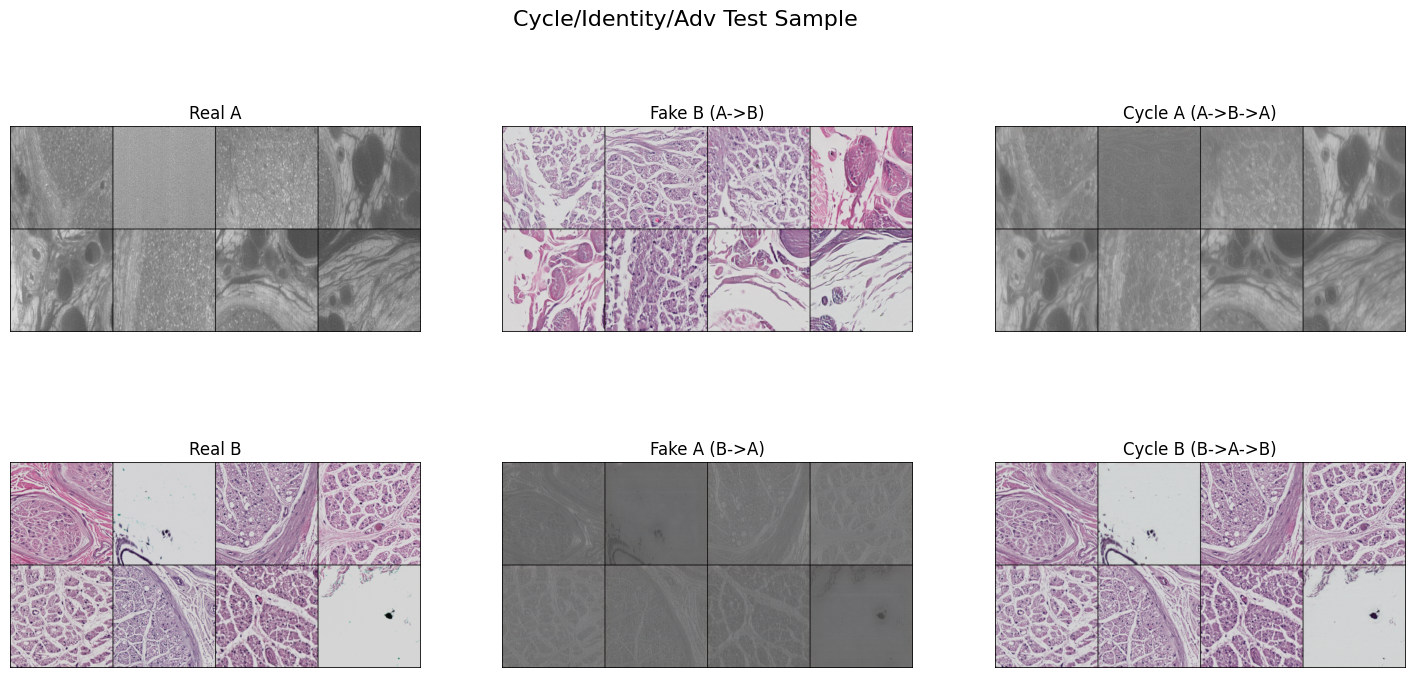

In [283]:
with torch.no_grad():
    sample_A, sample_B = next(iter(test_loader))
    sample_A = sample_A.to(device).float() / 255.0
    sample_B = sample_B.to(device).float() / 255.0

    fake_A, fake_B, idt_A, idt_B = model((sample_A, sample_B))
    cycle_A = model.G_B(fake_B)
    cycle_B = model.G_A(fake_A)

    grid_real_A  = make_grid(sample_A, nrow=4)
    grid_fake_B  = make_grid(fake_B, nrow=4)
    grid_cycle_A = make_grid(cycle_A, nrow=4)
    grid_real_B  = make_grid(sample_B, nrow=4)
    grid_fake_A  = make_grid(fake_A, nrow=4)
    grid_cycle_B = make_grid(cycle_B, nrow=4)

    plt.figure(figsize=(18, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(grid_real_A.permute(1, 2, 0).cpu().numpy())
    plt.title("Real A")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(grid_fake_B.permute(1, 2, 0).cpu().numpy())
    plt.title("Fake B (A->B)")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(grid_cycle_A.permute(1, 2, 0).cpu().numpy())
    plt.title("Cycle A (A->B->A)")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(grid_real_B.permute(1, 2, 0).cpu().numpy())
    plt.title("Real B")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(grid_fake_A.permute(1, 2, 0).cpu().numpy())
    plt.title("Fake A (B->A)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(grid_cycle_B.permute(1, 2, 0).cpu().numpy())
    plt.title("Cycle B (B->A->B)")
    plt.axis("off")

    plt.suptitle(f"Cycle/Identity/Adv Test Sample", fontsize=16)
    plt.show()

In [304]:
import os
import numpy as np
import tifffile as tiff
import torch

def create_gaussian_alpha_mask(ph, pw, sigma_ratio=0.25):
    """
    Create a Gaussian alpha mask with values between 0 and 1.
    The mask peaks at the center and smoothly tapers off at the edges.

    Args:
      ph (int): Tile height.
      pw (int): Tile width.
      sigma_ratio (float): Controls the spread; smaller values yield a sharper drop-off.

    Returns:
      mask (np.ndarray): A (ph, pw, 1) mask.
    """
    y = np.linspace(-1, 1, ph)
    x = np.linspace(-1, 1, pw)
    xx, yy = np.meshgrid(x, y)
    d = np.sqrt(xx**2 + yy**2)
    sigma = sigma_ratio
    mask = np.exp(- (d**2) / (2 * sigma**2))
    mask = mask / mask.max()
    return mask[..., None]

def convert_to_float01(img):
    """Convert image to float [0,1]."""
    if img.dtype == np.uint16:
        return img.astype(np.float32) / 65535
    elif img.dtype == np.uint8:
        return img.astype(np.float32) / 255
    else:
        return img.astype(np.float32)

def prepare_model_input(tile_float, mode):
    """
    Prepare input for the model.
    If mode is "A->B" and the tile is single-channel, replicate it to 3 channels.
    """
    H, W, C = tile_float.shape
    if mode == "A->B":
        if C == 1:
            return np.concatenate([tile_float] * 3, axis=2)
        return tile_float
    else:
        return tile_float

def inference_folder_tiles_overlap_blend(
    in_folder: str,
    out_folder: str,
    model_checkpoint: str,
    mode: str = "A->B",      # "A->B" for grayscale->color; "B->A" for color->grayscale.
    grid_shape = (5,7),      # Example: a 5x7 grid (35 tiles) per TIFF.
    overlap = (64,64),       # Overlap in pixels (height, width).
    sigma_ratio = 0.25,      # Controls Gaussian mask spread.
    use_tanh: bool = False,  # Set True if your model outputs in [-1,1].
    device: str = "cuda"
):
    """
    For each multi-page TIFF in `in_folder`, where each TIFF is a single slice
    containing a grid of overlapping tiles:
      1. Run inference on each tile via a CycleGAN generator.
      2. Stitch and blend the tiles into one final image using a Gaussian alpha mask.
      3. Save the stitched result in `out_folder`.
    """
    os.makedirs(out_folder, exist_ok=True)
    device_torch = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Using device: {device_torch}")

    model = CycleGAN(input_nc=3, output_nc=3, ngf=64, n_blocks=9).to(device_torch)
    state_dict = torch.load(model_checkpoint, map_location=device_torch)
    model.load_state_dict(state_dict)
    model.eval()

    # Select the correct generator based on mode.
    if mode == "A->B":
        print("[INFO] Mode: A->B => grayscale -> color")
        generator = model.G_A
        out_channels = 3
    elif mode == "B->A":
        print("[INFO] Mode: B->A => color -> grayscale")
        generator = model.G_B
        out_channels = 1
    else:
        raise ValueError("mode must be 'A->B' or 'B->A'.")

    # List all TIFF files in the input folder.
    valid_exts = {".tif", ".tiff"}
    tiff_files = [f for f in sorted(os.listdir(in_folder)) if os.path.splitext(f)[1].lower() in valid_exts]
    if not tiff_files:
        print(f"[WARN] No TIFF files found in {in_folder}.")
        return

    for fname in tiff_files:
        in_path = os.path.join(in_folder, fname)
        base, ext = os.path.splitext(fname)
        out_path = os.path.join(out_folder, base + "_inferred" + ext)
        print(f"\n[INFO] Processing {fname}")

        # Read the multi-page TIFF.
        tile_stack = tiff.imread(in_path)
        num_pages = tile_stack.shape[0]
        rows, cols = grid_shape
        expected_tiles = rows * cols
        if num_pages != expected_tiles:
            raise ValueError(f"Expected {expected_tiles} tiles but found {num_pages} in {fname}.")

        # Ensure each tile has shape (H, W, C).
        tiles = []
        for i in range(num_pages):
            tile = tile_stack[i]
            if tile.ndim == 2:
                tile = tile[..., np.newaxis]
            tiles.append(tile)
        tileH, tileW, _ = tiles[0].shape
        print(f"[INFO] Tile shape: {tileH}×{tileW}")

        # Compute mosaic dimensions.
        ov_h, ov_w = overlap
        stride_h = tileH - ov_h
        stride_w = tileW - ov_w
        mosaicH = tileH + (rows - 1) * stride_h
        mosaicW = tileW + (cols - 1) * stride_w

        mosaic = np.zeros((mosaicH, mosaicW, out_channels), dtype=np.float32)
        weight_map = np.zeros((mosaicH, mosaicW, 1), dtype=np.float32)

        idx = 0
        for r in range(rows):
            for c in range(cols):
                start_y = r * stride_h
                start_x = c * stride_w
                raw_tile = tiles[idx]
                idx += 1

                # Preprocess tile: scale to [0,1] and prepare channels.
                tile_float = convert_to_float01(raw_tile)
                tile_input = prepare_model_input(tile_float, mode)
                tile_tensor = torch.from_numpy(tile_input.transpose(2, 0, 1))[None].to(device_torch)
                if use_tanh:
                    tile_tensor = tile_tensor * 2 - 1

                # Run inference.
                with torch.no_grad():
                    out_t = generator(tile_tensor)
                    if use_tanh:
                        out_t = (out_t + 1) / 2
                out_np = out_t.squeeze(0).cpu().numpy()
                out_np = np.clip(out_np, 0, 1).transpose(1, 2, 0)
                if out_channels == 1 and out_np.shape[2] == 3:
                    out_np = out_np.mean(axis=2, keepdims=True)

                # Create the Gaussian alpha mask.
                alpha = create_gaussian_alpha_mask(tileH, tileW, sigma_ratio=sigma_ratio)
                mosaic[start_y:start_y+tileH, start_x:start_x+tileW, :] += out_np * alpha
                weight_map[start_y:start_y+tileH, start_x:start_x+tileW, 0] += alpha[..., 0]

        # Normalize mosaic by the weight map.
        mask_nonzero = (weight_map > 1e-8)
        mosaic_final = np.zeros_like(mosaic, dtype=np.float32)
        mosaic_final[mask_nonzero[:, :, 0]] = mosaic[mask_nonzero[:, :, 0]] / weight_map[mask_nonzero[:, :, 0]]
        mosaic_final = np.clip(mosaic_final, 0, 1)

        out_img = (mosaic_final * 65535).astype(np.uint16)
        if out_channels == 1:
            out_img = out_img[..., 0]

        if out_channels == 3:
            tiff.imwrite(out_path, out_img, photometric='rgb')
        else:
            tiff.imwrite(out_path, out_img, photometric='minisblack')
        print(f"[INFO] Saved inferred image to {out_path}")

    print("\nFinished processing all slices!")

if __name__ == "__main__":
    # Update these paths as needed.
    in_folder  = "/content/drive/MyDrive/GAN/MUSE_stitched_acq_4"
    out_folder = "/content/drive/MyDrive/GAN/stitched"
    ckpt_path  = "/content/drive/MyDrive/GAN/checkpoints/model_epoch_200.pth"

    inference_folder_tiles_overlap_blend(
        in_folder=in_folder,
        out_folder=out_folder,
        model_checkpoint=ckpt_path,
        mode="A->B",         # "A->B": grayscale -> color; "B->A": color -> grayscale.
        grid_shape=(5,7),    # Change grid dimensions if necessary.
        overlap=(64,64),
        sigma_ratio=0.25,    # Adjust for smoother or tighter blending.
        use_tanh=False,
        device="cuda"
    )
    print("Finished all slices!")


[INFO] Using device: cuda


<ipython-input-304-2ff90d13a9ad>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_checkpoint, map_location=device_torch)


[INFO] Mode: A->B => grayscale -> color

[INFO] Processing MUSE_stitched_acq_4_slice_000_tiles.tiff
[INFO] Tile shape: 512×512
[INFO] Saved inferred image to /content/drive/MyDrive/GAN/stitched/MUSE_stitched_acq_4_slice_000_tiles_inferred.tiff

[INFO] Processing MUSE_stitched_acq_4_slice_001_tiles.tiff
[INFO] Tile shape: 512×512
[INFO] Saved inferred image to /content/drive/MyDrive/GAN/stitched/MUSE_stitched_acq_4_slice_001_tiles_inferred.tiff

[INFO] Processing MUSE_stitched_acq_4_slice_002_tiles.tiff
[INFO] Tile shape: 512×512
[INFO] Saved inferred image to /content/drive/MyDrive/GAN/stitched/MUSE_stitched_acq_4_slice_002_tiles_inferred.tiff

[INFO] Processing MUSE_stitched_acq_4_slice_003_tiles.tiff
[INFO] Tile shape: 512×512
[INFO] Saved inferred image to /content/drive/MyDrive/GAN/stitched/MUSE_stitched_acq_4_slice_003_tiles_inferred.tiff

[INFO] Processing MUSE_stitched_acq_4_slice_004_tiles.tiff
[INFO] Tile shape: 512×512
[INFO] Saved inferred image to /content/drive/MyDrive/GAN